# Springboard Capstone 3: EDA
## RNA Secondary Structure Prediction

Data source: https://www.kaggle.com/competitions/stanford-ribonanza-rna-folding/data<br>
Using the QUICK START file

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('train_data_QUICK_START.csv')

Let's take get a sense of the dataframe structure/contents.

In [3]:
data.head()

,sequence_id,sequence,experiment_type,dataset_name,reactivity_0001,reactivity_0002,reactivity_0003,reactivity_0004,reactivity_0005,reactivity_0006,reactivity_0007,reactivity_0008,reactivity_0009,reactivity_0010,reactivity_0011,reactivity_0012,reactivity_0013,reactivity_0014,reactivity_0015,reactivity_0016,reactivity_0017,reactivity_0018,reactivity_0019,reactivity_0020,reactivity_0021,reactivity_0022,reactivity_0023,reactivity_0024,reactivity_0025,reactivity_0026,reactivity_0027,reactivity_0028,reactivity_0029,reactivity_0030,reactivity_0031,reactivity_0032,reactivity_0033,reactivity_0034,reactivity_0035,reactivity_0036,...,reactivity_error_0167,reactivity_error_0168,reactivity_error_0169,reactivity_error_0170,reactivity_error_0171,reactivity_error_0172,reactivity_error_0173,reactivity_error_0174,reactivity_error_0175,reactivity_error_0176,reactivity_error_0177,reactivity_error_0178,reactivity_error_0179,reactivity_error_0180,reactivity_error_0181,reactivity_error_0182,reactivity_error_0183,reactivity_error_0184,reactivity_error_0185,reactivity_error_0186,reactivity_error_0187,reactivity_error_0188,reactivity_error_0189,reactivity_error_0190,reactivity_error_0191,reactivity_error_0192,reactivity_error_0193,reactivity_error_0194,reactivity_error_0195,reactivity_error_0196,reactivity_error_0197,reactivity_error_0198,reactivity_error_0199,reactivity_error_0200,reactivity_error_0201,reactivity_error_0202,reactivity_error_0203,reactivity_error_0204,reactivity_error_0205,reactivity_error_0206
0,0000d87cab97,GGGAACGACUCGAGUAGAGUCGAAAAAGAUCGCCACGCACUUACGA...,2A3_MaP,DasLabBigLib_OneMil_RFAM_windows_100mers_2A3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023,-0.039,0.114,0.019,0.171,-0.162,0.094,0.000,0.247,-0.440,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000d87cab97,GGGAACGACUCGAGUAGAGUCGAAAAAGAUCGCCACGCACUUACGA...,DMS_MaP,DasLabBigLib_OneMil_RFAM_windows_100mers_DMS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.727,0.086,0.157,-0.021,0.031,0.034,0.140,-0.023,0.138,0.105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0001ca9d21b0,GGGAACGACUCGAGUAGAGUCGAAAAGGUGGCCGGCAGAAUCGCGA...,2A3_MaP,DasLabBigLib_OneMil_OpenKnot_Round_2_train_2A3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.372,0.097,0.179,0.550,-0.475,0.111,-0.363,0.492,-1.039,1.118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0001ca9d21b0,GGGAACGACUCGAGUAGAGUCGAAAAGGUGGCCGGCAGAAUCGCGA...,DMS_MaP,DasLabBigLib_OneMil_OpenKnot_Round_2_train_DMS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.075,0.500,0.050,-0.051,0.274,0.200,0.250,-0.077,0.172,0.876,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00021f968267,GGGAACGACUCGAGUAGAGUCGAAAACAUUGUUAAUGCCUAUAUUA...,2A3_MaP,DasLabBigLib_OneMil_Replicates_from_previous_l...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.288,1.012,0.854,1.179,0.177,0.217,0.327,0.193,0.077,0.359,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.columns

Index(['sequence_id', 'sequence', 'experiment_type', 'dataset_name',
       'reactivity_0001', 'reactivity_0002', 'reactivity_0003',
       'reactivity_0004', 'reactivity_0005', 'reactivity_0006',
       ...
       'reactivity_error_0197', 'reactivity_error_0198',
       'reactivity_error_0199', 'reactivity_error_0200',
       'reactivity_error_0201', 'reactivity_error_0202',
       'reactivity_error_0203', 'reactivity_error_0204',
       'reactivity_error_0205', 'reactivity_error_0206'],
      dtype='object', length=416)

In [5]:
data.isnull().sum()

sequence_id                   0
sequence                      0
experiment_type               0
dataset_name                  0
reactivity_0001          335616
                          ...  
reactivity_error_0202    335616
reactivity_error_0203    335616
reactivity_error_0204    335616
reactivity_error_0205    335616
reactivity_error_0206    335616
Length: 416, dtype: int64

In [6]:
data.shape

(335616, 416)

The thing to be predicted are the reactivities, described at the data source as: <p>
An array of floating point numbers of the train data, should have the same length as the RNA sequence, which defines the reactivity profile for the RNA. These are the type of data that need to be predicted in this competition. For sequences shorter than the maximum RNA length, positions that go beyond the sequence length have null. Several positions near the beginning and end of the sequence also cannot be probed due to technical reasons, and their reactivity values are null. The values should be greater than or equal to zero, but due to experimental errors can become negative. The values are normalized so that the 90th percentile value within each dataset is 1.0.<p>
The reactivity_error columns are the errors associated with each reactivity measurement.

In [7]:
reactivity_cols = []
reactivity_error_cols = []

for col in data.columns:
    if 'reactivity' in col:
        if 'error' in col:
            reactivity_error_cols.append(col)
        else:
            reactivity_cols.append(col)

print("# Reactivity Columns: ", len(reactivity_cols))
print("# Reactivity Error Columns: ", len(reactivity_error_cols))

# Reactivity Columns:  206
# Reactivity Error Columns:  206


In [8]:
nulls = data[reactivity_cols].isnull().sum()
noNulls = data[reactivity_cols].loc[:, nulls == 0]
print("Mean of means:", noNulls.mean().mean())
noNulls.describe()

Mean of means: 0.3780205924610874


,reactivity_0027,reactivity_0028,reactivity_0029,reactivity_0030,reactivity_0031,reactivity_0032,reactivity_0033,reactivity_0034,reactivity_0035,reactivity_0036,reactivity_0037,reactivity_0038,reactivity_0039,reactivity_0040,reactivity_0041,reactivity_0042,reactivity_0043,reactivity_0044,reactivity_0045,reactivity_0046,reactivity_0047,reactivity_0048,reactivity_0049,reactivity_0050,reactivity_0051,reactivity_0052,reactivity_0053,reactivity_0054,reactivity_0055,reactivity_0056,reactivity_0057,reactivity_0058,reactivity_0059,reactivity_0060,reactivity_0061,reactivity_0062,reactivity_0063,reactivity_0064,reactivity_0065,reactivity_0066,reactivity_0067,reactivity_0068,reactivity_0069,reactivity_0070,reactivity_0071,reactivity_0072,reactivity_0073,reactivity_0074,reactivity_0075,reactivity_0076,reactivity_0077,reactivity_0078,reactivity_0079,reactivity_0080,reactivity_0081,reactivity_0082,reactivity_0083,reactivity_0084,reactivity_0085,reactivity_0086,reactivity_0087,reactivity_0088,reactivity_0089,reactivity_0090,reactivity_0091,reactivity_0092,reactivity_0093,reactivity_0094,reactivity_0095
count,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000,335616.000000
mean,0.321187,0.305963,0.321516,0.512611,0.379869,0.306806,0.328433,0.342372,0.365122,0.367725,0.401557,0.521748,0.419106,0.411051,0.403289,0.402094,0.415620,0.413488,0.420654,0.421872,0.410762,0.401386,0.415176,0.429618,0.411911,0.393871,0.396258,0.390132,0.386351,0.381907,0.377786,0.381626,0.390094,0.399179,0.393612,0.399425,0.399042,0.396540,0.395698,0.386784,0.379133,0.381667,0.380237,0.377087,0.376857,0.361291,0.368685,0.370699,0.380762,0.383051,0.365850,0.369772,0.369684,0.362593,0.360073,0.364834,0.367404,0.354123,0.346734,0.366485,0.343561,0.329856,0.328734,0.332291,0.334851,0.330067,0.328338,0.329609,0.319856
std,0.476204,0.462562,0.487640,0.955742,0.576890,0.518787,0.538292,0.537716,0.576853,0.577712,0.609995,0.742239,0.647755,0.657380,0.663344,0.655742,0.674241,0.683152,0.735574,0.742547,0.722268,0.705109,0.706157,0.720370,0.681929,0.666029,0.659247,0.651043,0.647693,0.631712,0.629055,0.621302,0.632489,0.644370,0.633086,0.634662,0.632599,0.637751,0.627794,0.621002,0.617495,0.616864,0.615076,0.621935,0.610682,0.593169,0.600199,0.618023,0.622831,0.620566,0.600204,0.617004,0.625122,0.604856,0.601415,0.604980,0.610674,0.601702,0.588805,0.614631,0.594254,0.575504,0.575743,0.569349,0.567223,0.553833,0.555799,0.555548,0.549280
min,-13.315000,-9.740000,-12.970000,-8.866000,-13.000000,-13.303000,-12.723000,-10.698000,-23.087000,-12.750000,-14.539000,-15.045000,-10.028000,-17.692000,-9.489000,-17.992000,-13.271000,-13.968000,-16.417000,-10.462000,-9.229000,-11.806000,-15.874000,-10.672000,-14.315000,-16.170000,-17.993000,-9.090000,-10.465000,-23.097000,-16.079000,-9.046000,-7.666000,-10.081000,-10.130000,-12.935000,-13.525000,-10.252000,-12.326000,-12.143000,-11.100000,-13.545000,-11.711000,-9.774000,-15.293000,-14.071000,-12.083000,-6.976000,-8.513000,-22.867000,-10.265000,-11.163000,-8.132000,-18.440000,-12.707000,-9.038000,-7.925000,-17.151000,-21.061000,-10.005000,-14.437000,-12.414000

In [9]:
someNulls = data[reactivity_cols].loc[:, nulls.between(0, 335616, inclusive = 'neither')]
print("Mean of means:", someNulls.mean().mean())
someNulls.describe()

Mean of means: 0.31105148583726294


,reactivity_0096,reactivity_0097,reactivity_0098,reactivity_0099,reactivity_0100,reactivity_0101,reactivity_0102,reactivity_0103,reactivity_0104,reactivity_0105,reactivity_0106,reactivity_0107,reactivity_0108,reactivity_0109,reactivity_0110,reactivity_0111,reactivity_0112,reactivity_0113,reactivity_0114,reactivity_0115,reactivity_0116,reactivity_0117,reactivity_0118,reactivity_0119,reactivity_0120,reactivity_0121,reactivity_0122,reactivity_0123,reactivity_0124,reactivity_0125,reactivity_0126,reactivity_0127,reactivity_0128,reactivity_0129,reactivity_0130,reactivity_0131,reactivity_0132,reactivity_0133,reactivity_0134,reactivity_0135,reactivity_0136,reactivity_0137,reactivity_0138,reactivity_0139,reactivity_0140,reactivity_0141,reactivity_0142,reactivity_0143,reactivity_0144,reactivity_0145,reactivity_0146,reactivity_0147,reactivity_0148,reactivity_0149,reactivity_0150,reactivity_0151,reactivity_0152,reactivity_0153,reactivity_0154,reactivity_0155,reactivity_0156,reactivity_0157,reactivity_0158,reactivity_0159,reactivity_0160,reactivity_0161,reactivity_0162,reactivity_0163,reactivity_0164,reactivity_0165
count,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,330462.000000,35674.000000,35674.00000,35674.000000,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000,8420.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000
mean,0.349074,0.343219,0.348221,0.349102,0.366586,0.350750,0.372169,0.367019,0.378640,0.318108,0.323034,0.316131,0.323644,0.321846,0.318680,0.324036,0.326510,0.341795,0.371045,0.476873,0.365564,0.334015,0.285955,0.265518,0.255107,0.259861,0.257398,0.274328,0.298712,0.383795,0.552247,0.394337,0.44588,0.580376,0.511167,0.441267,0.293239,0.300679,0.199426,0.329379,0.033793,0.071947,-0.000550,0.041488,0.036514,0.014662,0.012255,0.447839,0.025765,0.138063,0.052762,0.227353,0.164552,2.525814,0.032154,0.092977,0.015465,0.092525,0.514958,0.111193,0.237314,0.254213,0.144426,0.126507,0.184674,0.236596,0.300660,0.447932,0.479034,0.695988
std,0.586014,0.580471,0.579183,0.558966,0.588411,0.544427,0.575251,0.599052,0.584707,0.537684,0.555325,0.537932,0.558628,0.576153,0.584561,0.576148,0.578629,0.596765,0.630616,0.744751,0.609924,0.585904,0.505713,0.476980,0.461841,0.463348,0.453253,0.463669,0.472502,0.527419,0.703678,0.541791,0.58559,0.679880,0.565996,0.622703,0.437376,0.466379,0.296393,0.453930,0.198901,0.202501,0.116155,0.178134,0.150189,0.115942,0.123419,0.976007,0.145271,0.426955,0.130856,0.320426,0.222856,4.457931,0.144252,0.189608,0.148468,0.196860,0.793183,0.331779,0.388641,0.500788,0.355721,0.378177,0.426419,0.423401,0.332674,0.350139,0.507224,0.677479
min,-7.771000,-18.832000,-17.252000,-10.414000,-20.733000,-14.580000,-11.029000,-11.856000,-9.597000,-8.959000,-11.410000,-9.702000,-9.886000,-15.175000,-10.643000,-17.494000,-22.076000,-9.072000,-12.831000,-9.112000,-13.481000,-8.725000,-12.292000,-18.938000,-13.631000,-11.602000,-25.674000,-13.326000,-14.366000,-13.181000,-13.482000,-9.173000,-9.73300,-14.568000,-1.543000,-2.127000,-1.798000,-2.597000,-1.872000,-1.189000,-1.339000,-1.080000,-0.679000,-0.659000,-0.541000,-0.626000,-0.855000,-0.682000,-1.013000,-0.600000,-0.749000,-0.562000,-0.405000,-0.517000,-0.601000,-0.833000,-1.299000,-1.011000,-0.397000,-1.065000,-1.661000,-1.782000,-1.478000,-1.800000,-0.949000,-1.175000,-1.245000,-0.2

It looks like the mean is pretty close to 0 and doesn't change too much between positions with no null values and those with some null values. Let's fill null values with 0.3 for now.

These data are generated with two different probes: DMS, which reacts with the base-pairing faces of specific nucleotides, and 2A3, which probes the RNA backbone. Let's confirm that each sequence has a reactivity profile from each probe and investigate how different they are for all or a subset of the sequences.

In [10]:
#separate dataframes by probe
dmsDF = data[data['experiment_type'] == 'DMS_MaP']
twoA3DF = data[data['experiment_type'] == '2A3_MaP']

dmsReactDF = dmsDF[reactivity_cols].fillna(0.3)
twoA3ReactDF = twoA3DF[reactivity_cols].fillna(0.3)

# combine reactivity values into single array for each entry
dmsArrays = [row.values for idx, row in dmsReactDF.iterrows()]
twoA3Arrays = [row.values for idx, row in twoA3ReactDF.iterrows()]

In [11]:
print("# DMS Values:", len(dmsDF))
print("# 2A3 Values:", len(twoA3DF))

setDMS = set(dmsDF['sequence_id'])
set2A3 = set(twoA3DF['sequence_id'])
print("Sequence IDs probed with DMS but not 2A3:", setDMS.difference(set2A3))
print("Sequence IDs probed with 2A3 but not DMS:", set2A3.difference(setDMS))

# DMS Values: 167808
# 2A3 Values: 167808
Sequence IDs probed with DMS but not 2A3: set()
Sequence IDs probed with 2A3 but not DMS: set()


In [12]:
# calculate differences by probe
probeL2 = [np.linalg.norm(dmsArrays[i] - twoA3Arrays[i]) for i in range(len(dmsArrays))]
dmsDF.loc[:, 'L2'] = probeL2
print("Summary Statistics of L2 Distances of Reactivities between Probes:")
dmsDF['L2'].describe()

Summary Statistics of L2 Distances of Reactivities between Probes:


C:\Users\dkoul\AppData\Local\Temp\ipykernel_47404\829786148.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dmsDF.loc[:, 'L2'] = probeL2


count    167808.000000
mean          7.597973
std           2.132316
min           2.150343
25%           6.222359
50%           7.214103
75%           8.489462
max          39.519454
Name: L2, dtype: float64

So it looks like we do have info with both probes for every sequence (at least in the Quick Start set that I'm using here). The distances between the two are not negligible, so we will need to take probe identity into account when we do the modeling.

Now, let's explore existing algorithmic predictions for the available sequences.

Code below generates a dataframe, viennaDF, that has the sequences and sequence IDs as well as columns from Vienna algorithm predictions for the sequences. The two columns are <b>ss</b>, the predicted secondary structure in dot-bracket notation, where a dot indicates an unpaired base and a bracket indicates a paired one; and <b>mfe</b>, the mean free energy of the corresponding structure.

The predictions take a long time to run, so the dataframe is pickled at the end of this so that that this section does not need to be run in its entirety every time. Skip ahead to unpickling if not needed.

<hr>

In [13]:
'''
# submodule imports
import RNA # Vienna - most useful documentation is at https://viennarna.readthedocs.io/en/latest/examples/python.html
'''

'\n# submodule imports\nimport RNA # Vienna - most useful documentation is at https://viennarna.readthedocs.io/en/latest/examples/python.html\n'

In [14]:
'''
viennaDF = dmsDF[['sequence_id', 'sequence']].reset_index(drop = True)

# (ss, mfe) = RNA.fold(seq1)
viennaDF['ss'], viennaDF['mfe'] = zip(*(RNA.fold(seq) for seq in viennaDF['sequence']))
'''

"\nviennaDF = dmsDF[['sequence_id', 'sequence']].reset_index(drop = True)\n\n# (ss, mfe) = RNA.fold(seq1)\nviennaDF['ss'], viennaDF['mfe'] = zip(*(RNA.fold(seq) for seq in viennaDF['sequence']))\n"

In [15]:
'''
# pickle for later
viennaDF.to_pickle('viennaDF.pkl')
'''

"\n# pickle for later\nviennaDF.to_pickle('viennaDF.pkl')\n"

<hr>

In [16]:
# unpickling if necessary
viennaDF = pd.read_pickle('viennaDF.pkl')

In [17]:
# confirm how much length of sequences varies & whether we will need to pad
data['seq_length'] = [len(x) for x in data['sequence']]
data['seq_length'].describe()

count    335616.000000
mean        175.652037
std           8.854856
min         115.000000
25%         177.000000
50%         177.000000
75%         177.000000
max         206.000000
Name: seq_length, dtype: float64

We now have several pieces of information and we can look at how they correlate. 
- position in sequence
- base identity
- paired or unpaired (Vienna prediction)
- backbone reactivity
- selected base reactivity
- surrounding bases

In [18]:
# Pull out secondary structure predictions into a separate dataframe
# One column per position, with P for paired, U for unpaired, or N for None (padding)

#tokenize
ssVienna = viennaDF['ss'].apply(list)

# pad
maxlength = data['seq_length'].max()
ssVienna_padded = ssVienna.apply(lambda x: x + ['N']*(maxlength - len(x)))

ssVienna_pdexp =  pd.DataFrame(np.vstack(ssVienna_padded))
ssViennaDF = ssVienna_pdexp.replace({'(': 'P', ')': 'P', '.': 'U'})

In [19]:
def findbase(base, sequence):
    '''Generator with all indices where a given base is found in the string RNA sequence'''
    return (i for i, ltr in enumerate(sequence) if ltr == base)

def findbaseDF(base, series):
    '''Iterates the findbase function over a pandas series or equivalent'''
    all_indices = []
    for seq in series:
        idx = findbase(base, seq)
        all_indices += list(idx)
    return all_indices

def vals_from_df(base, dataframe, sequence_series):
    '''Takes dataframe where each row is one RNA sample and each column is some value or readout for a position
    in the sequence and extracts it into one long list that can serve as feature column for other dataframe.'''
    all_values = []
    for i, seq in enumerate(sequence_series):
        idx = findbase(base, seq)
        values = dataframe.iloc[i, idx]
        all_values += list(values)
    return all_values

def populate_properties(base, columns, source_dict):
    '''Uses the above functions to create a dataframe for a particular base containing data for the properties
    outlined as keys of the source_dict from the sources indicated in the dictionary.'''
    df = pd.DataFrame(columns = columns)
    for property in source_dict.keys():
        if property == 'position':
            df[property] = findbaseDF(base, source_dict[property])
        else:
            df[property] = vals_from_df(base, source_dict[property], source_dict['position'])
    return df
    

Code below takes a long time; so dataframes are pickled at the end. Initially run code is commented out and pickle files are loaded again for subsequent work sessions.
<hr>

In [20]:
'''
columns = ['position', 'paired', '2A3_react', 'DMS_react']
source_dict = {'position': dmsDF['sequence'], 'paired': ssViennaDF, '2A3_react': twoA3ReactDF, 'DMS_react': dmsReactDF}

dfG = populate_properties('G', columns, source_dict)
dfA = populate_properties('A', columns, source_dict)
dfC = populate_properties('C', columns, source_dict)
dfU = populate_properties('U', columns, source_dict)
'''

"\ncolumns = ['position', 'paired', '2A3_react', 'DMS_react']\nsource_dict = {'position': dmsDF['sequence'], 'paired': ssViennaDF, '2A3_react': twoA3ReactDF, 'DMS_react': dmsReactDF}\n\ndfG = populate_properties('G', columns, source_dict)\ndfA = populate_properties('A', columns, source_dict)\ndfC = populate_properties('C', columns, source_dict)\ndfU = populate_properties('U', columns, source_dict)\n"

In [21]:
'''
# pickle all of the above dataframes for later use
dfG.to_pickle('dfG.pkl')
dfA.to_pickle('dfA.pkl')
dfC.to_pickle('dfC.pkl')
dfU.to_pickle('dfU.pkl')
'''

"\n# pickle all of the above dataframes for later use\ndfG.to_pickle('dfG.pkl')\ndfA.to_pickle('dfA.pkl')\ndfC.to_pickle('dfC.pkl')\ndfU.to_pickle('dfU.pkl')\n"

<hr>

In [22]:
# code to unpickle when necessary
dfG = pd.read_pickle('dfG.pkl')
dfA = pd.read_pickle('dfA.pkl')
dfC = pd.read_pickle('dfC.pkl')
dfU = pd.read_pickle('dfU.pkl')

Let's explore how the different features/properties break down for the different bases.

In [23]:
df = pd.concat([dfA, dfC, dfG, dfU], keys = ['A', 'C', 'G', 'U'])
df.index.rename(['base', 'index'], inplace = True)
df.reset_index(level = 0, inplace = True)
df.head()

,base,position,paired,2A3_react,DMS_react
index,,,,,
0,A,3,P,0.3,0.3
1,A,4,P,0.3,0.3
2,A,7,P,0.3,0.3
3,A,12,U,0.3,0.3
4,A,15,U,0.3,0.3


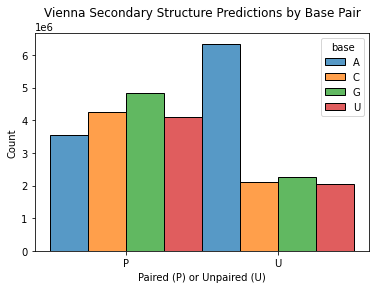

In [24]:
sns.histplot(df, x = 'paired', hue = 'base', multiple = 'dodge')
plt.xlabel('Paired (P) or Unpaired (U)')
plt.title('Vienna Secondary Structure Predictions by Base Pair')
plt.show()

Interesting! It looks like all three bases other than adenine are predicted to be paired, while adenine alone is much more likely to be predicted to be unpaired.

In [25]:
df[['position', '2A3_react', 'DMS_react']].corr()

,position,2A3_react,DMS_react
position,1.000000,-0.050460,-0.018922
2A3_react,-0.050460,1.000000,0.177869
DMS_react,-0.018922,0.177869,1.000000


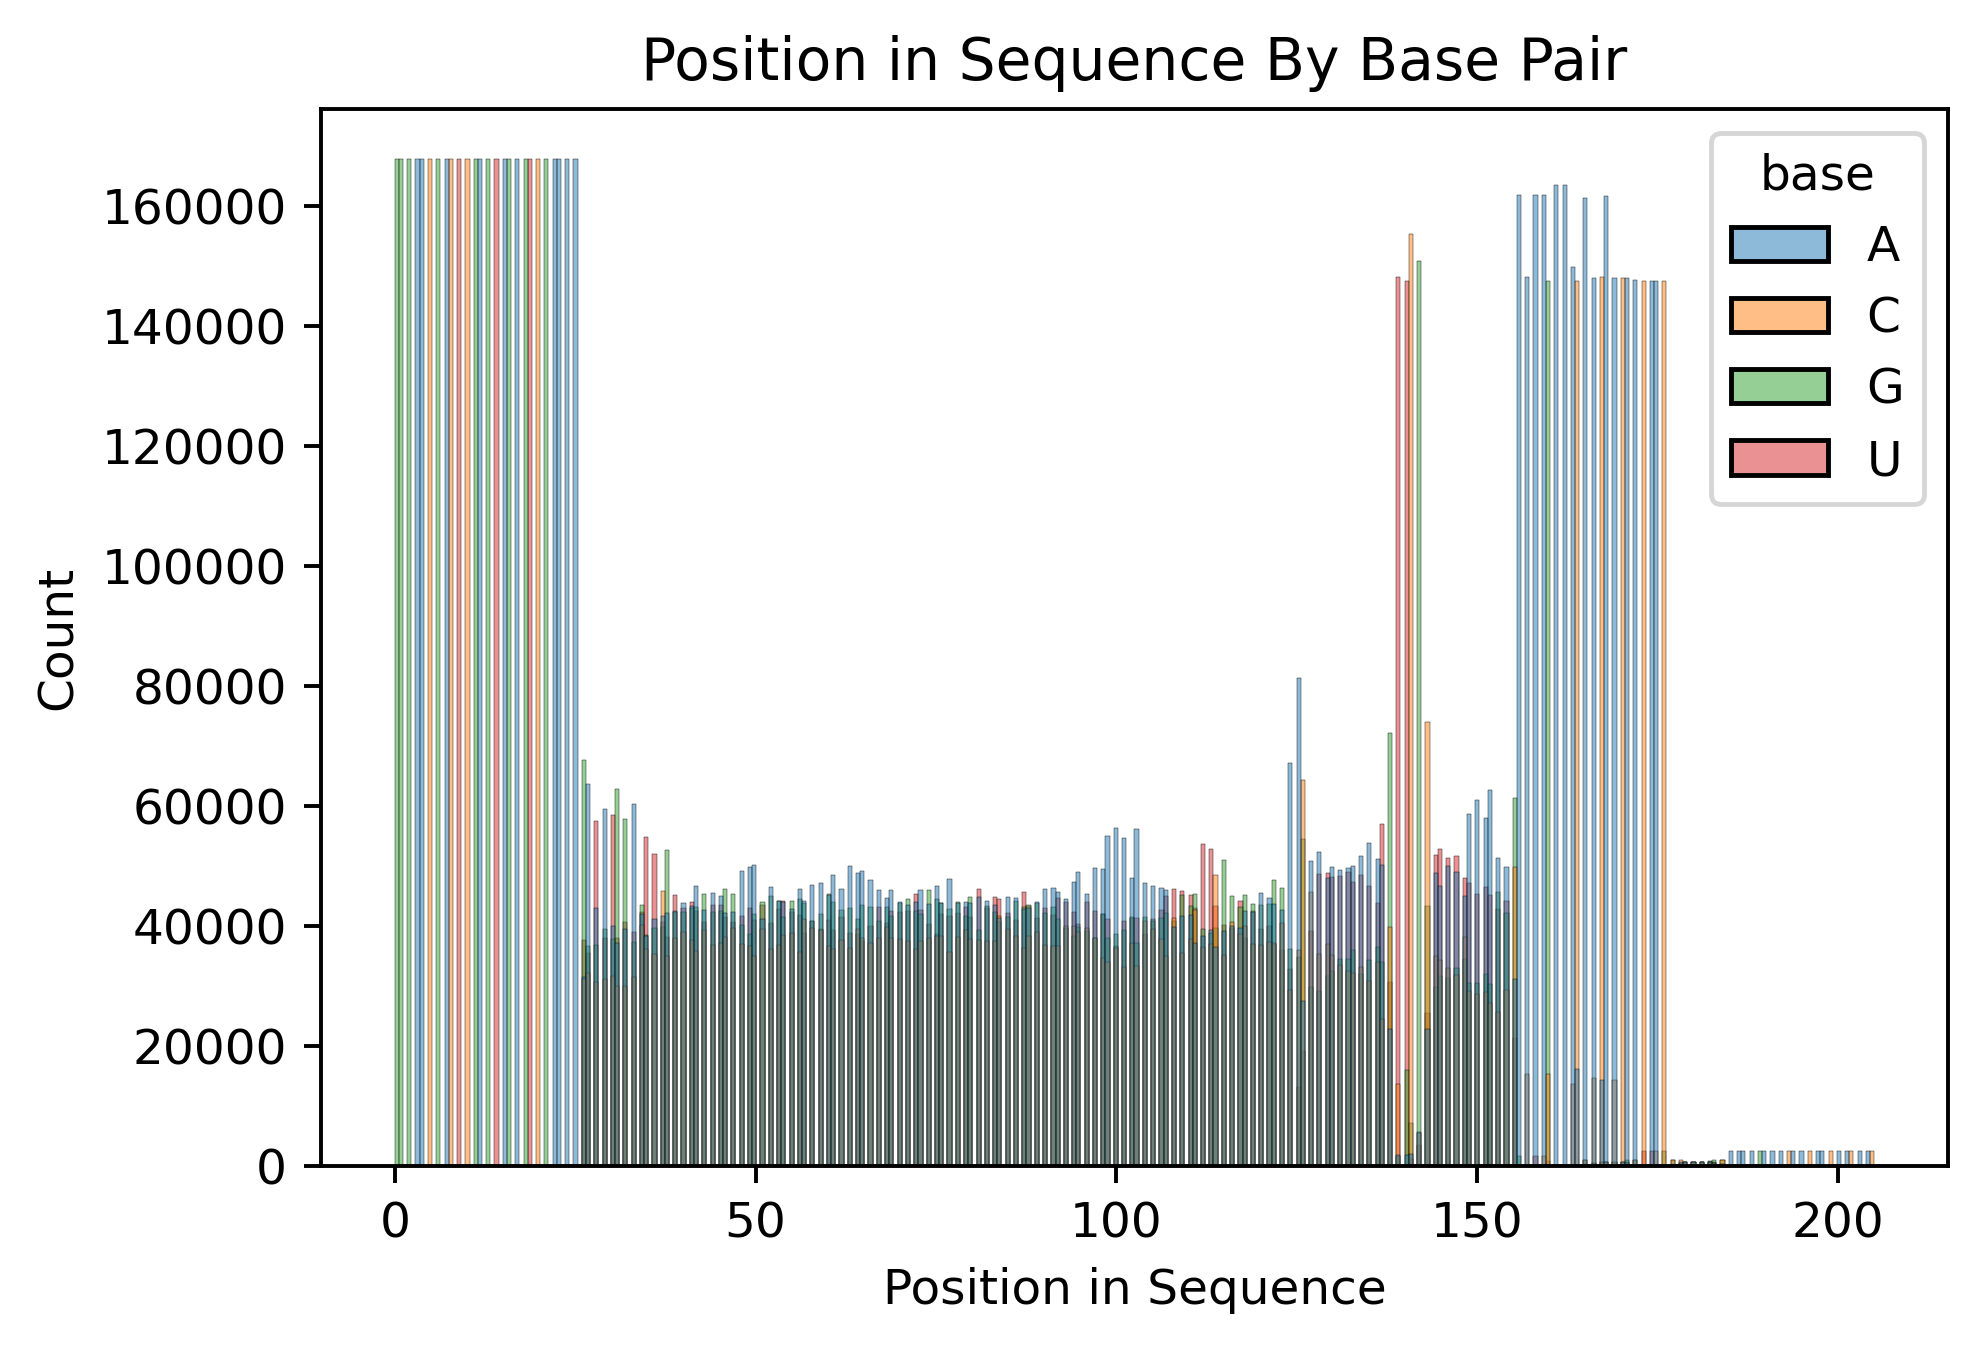

In [29]:
plt.figure(dpi = 350)
sns.histplot(df, x = 'position', hue='base', alpha = 0.5)
plt.xlabel('Position in Sequence')
plt.title('Position in Sequence By Base Pair')
plt.show()

Some potentially interesting observations here as well - the beginnings and ends of the RNA sequence seem to exhibit more bias towards certain bases than the middle. For the first ~30 nucleotides, this seems VERY positionally dependent - we see  all four colors intermixed by each position seems strongly biased towards one particular base pair. The ends seems to have a lot of As and Cs - the former would make sense if a lot a of these sequences include a polyA tail, although I don't have a great guess as to why C's would predominate. There is also a chunk at around 140 bases that seems to show a sequence preference spike. It would be interesting to see if these positional preferences correspond to certain types of secondary (or tertiary) structures.

Next let's take a look at how the reactivity profiles change depending on the base identity.

In [58]:
def get_stats(base):
    df = eval('df'+base)
    stat2A3 = df['2A3_react'].describe()
    statDMS = df['DMS_react'].describe()
    return pd.DataFrame([stat2A3, statDMS])

In [60]:
statsA = get_stats('A')
statsC = get_stats('C')
statsG = get_stats('G')
statsU = get_stats('U')

stats = pd.concat([statsA, statsC, statsG, statsU], keys = ['A', 'C', 'G', 'U'])
stats

count      mean       std     min    25%    50%    75%     max
A 2A3_react  9878144.0  0.372568  0.423468  -5.732  0.300  0.300  0.300  21.265
  DMS_react  9878144.0  0.501538  0.542626 -21.061  0.300  0.300  0.566  31.961
C 2A3_react  6347082.0  0.259377  0.362956 -13.000  0.075  0.300  0.300  13.957
  DMS_react  6347082.0  0.416494  0.620431 -17.993  0.161  0.300  0.339  35.815
G 2A3_react  7091160.0  0.287062  0.376943  -9.545  0.097  0.300  0.300  23.341
  DMS_react  7091160.0  0.164598  0.216921 -22.867  0.034  0.206  0.300   9.679
U 2A3_react  6159431.0  0.480104  0.583039  -9.752  0.209  0.300  0.582  16.714
  DMS_react  6159431.0  0.134060  0.231782 -25.674  0.000  0.090  0.300  10.113

Looking at the summary statistics for the two probe reactivities broken down by base pair. While the means are fairly similar across all rows, we see quite large differences in the min and max values. The max DMS reactivity is significantly higher A and C, as would be expected since the general method using this probe detects methylation at N1 of adenine and N3 of cytosine. Differences in backbone flexibility (2A3) are somewhat less pronounced, with C and U having slightly lower maxima than A and G and all except A having very similar minima.

<hr>

Below are some initial explorations that I did that don't quite fit in with the flow of how I ended up exploring my variables above. However, leaving the code (and outputs) in here for my own future reference.

In [9]:
reactivityDF = data[reactivity_cols]
nulls = reactivityDF.isnull().sum()
nulls.describe()

count       206.000000
mean     172012.077670
std      165992.464631
min           0.000000
25%           0.000000
50%      313569.000000
75%      335616.000000
max      335616.000000
dtype: float64

In [10]:
# Find which columns are entirely null values
allNulls = reactivityDF.loc[:, nulls == 335616]
print(allNulls.columns)

Index(['reactivity_0001', 'reactivity_0002', 'reactivity_0003',
       'reactivity_0004', 'reactivity_0005', 'reactivity_0006',
       'reactivity_0007', 'reactivity_0008', 'reactivity_0009',
       'reactivity_0010', 'reactivity_0011', 'reactivity_0012',
       'reactivity_0013', 'reactivity_0014', 'reactivity_0015',
       'reactivity_0016', 'reactivity_0017', 'reactivity_0018',
       'reactivity_0019', 'reactivity_0020', 'reactivity_0021',
       'reactivity_0022', 'reactivity_0023', 'reactivity_0024',
       'reactivity_0025', 'reactivity_0026', 'reactivity_0166',
       'reactivity_0167', 'reactivity_0168', 'reactivity_0169',
       'reactivity_0170', 'reactivity_0171', 'reactivity_0172',
       'reactivity_0173', 'reactivity_0174', 'reactivity_0175',
       'reactivity_0176', 'reactivity_0177', 'reactivity_0178',
       'reactivity_0179', 'reactivity_0180', 'reactivity_0181',
       'reactivity_0182', 'reactivity_0183', 'reactivity_0184',
       'reactivity_0185', 'reactivity_01

One very - probably overly - simple way to think of this is as a translation problem - you have only a few "words" in the original language (the nucleotides) but the context dictates the reactivity ("language" to be translated to). To try to get a better sense of the relationship, we will do a LTSM and see what looks like.

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, StringLookup
from tensorflow.keras.preprocessing.text import Tokenizer

In [13]:
# tokenize
seq_tokens = data['sequence'].apply(list)

# pad
maxlength = data['seq_length'].max()
seq_tokens_padded = seq_tokens.apply(lambda x: x + ['0']*(maxlength - len(x)))

In [14]:
# confirm that all sequences are the same length
seq_tokens_padded.apply(lambda x: len(x)).describe()

count    335616.0
mean        206.0
std           0.0
min         206.0
25%         206.0
50%         206.0
75%         206.0
max         206.0
Name: sequence, dtype: float64

In [15]:
# reshape for input into string lookup
seq_tokens_padded = seq_tokens_padded.apply(lambda x: np.array(x))
seq_tokens_padded = np.stack(seq_tokens_padded)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(seq_tokens_padded, reactivityDF)

In [16]:
RNAvocab = ["A", "C", "G", "U", "T"]

layer = StringLookup(vocabulary = RNAvocab, mask_token = "0")
encoded_seqs = layer(X_train)

In [42]:
# Make the Model
model = Sequential()
model.add(StringLookup(vocabulary = RNAvocab, mask_token = "0"))
model.add(Embedding(input_dim = len(RNAvocab)+1, input_length = maxlength, output_dim = 5))
model.add(LSTM(5, return_sequences = True))
model.add(LSTM(5))
model.add(Dense(maxlength, activation = 'softmax'))
model.compile(loss='mse',optimizer ='adam',metrics=['accuracy'])

In [43]:
model.fit(X_train, y_train, epochs = 10, batch_size = 500, validation_split = 0.10)

Epoch 1/10
454/454 [==============================] - 192s 412ms/step - loss: nan - accuracy: 8.8285e-06 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/10
454/454 [==============================] - 231s 510ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/10
454/454 [==============================] - 224s 494ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/10
454/454 [==============================] - 233s 514ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/10
454/454 [==============================] - 232s 512ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/10
454/454 [==============================] - 234s 516ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/10
454/454 [==============================] - 236s 521ms/step - loss: nan - accuracy: 0.0000e+00 - val_l

In [44]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 string_lookup_8 (StringLoo  (None, 206)               0         
 kup)                                                            
                                                                 
 embedding_3 (Embedding)     (None, 206, 5)            30        
                                                                 
 lstm_9 (LSTM)               (None, 206, 5)            220       
                                                                 
 lstm_10 (LSTM)              (None, 5)                 220       
                                                                 
 dense_6 (Dense)             (None, 206)               1236      
                                                                 
Total params: 1706 (6.66 KB)
Trainable params: 1706 (6.66 KB)
Non-trainable params: 0 (0.00 Byte)
______________________